<h3 align="center">NEU 437/537</h3>
<h4 align="center">Princeton University, Spring 2022</h4>

---
## Homework 3: Generalized Linear Models (GLMs)
#### Due: Friday, Apr 8

---
### Formatting Instructions
- Please prepare your homework submission completely within your own copy of this colab notebook.

- For each problem or sub-problem, please **limit yourself to one Code cell and/or one Markdown cell** as appropriate (switch between them by using the menu at the top, or the shortcuts `Ctrl+M M` for Markdown and `Ctrl+M Y` for Code). 

- **Submitting your homework**:  Please submit an .ipynb file via the assignment tab in Canvas. (From your notebook, File->Download->Download .ipynb).  Late submissions will be penalized 10% per day.

- **Test before submmitting**: Before submitting, make sure to verify that your code runs without  errors by selecting `Runtime -> Restart & Run All`. 


---
Setup: let's run a magic command (to force inline plotting) and then import some of our favorite packages.

In [3]:
%matplotlib inline

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
! pip install pyglmnet # install pyglmnet into colab environment
from pyglmnet import GLM
from scipy.linalg import hankel
from scipy.interpolate import interp1d


In [4]:
colors = plt.cm.Dark2(np.linspace(0, 1, 10))


In this problem set, you will fit two **classical GLMs** (linear-Gaussian and Poisson) to spike train data. The goal in many neuroscience experiments is to find out what drives a neuron to spike. This is called an **encoding model**, since we are predicting neuronal spiking activity based on the stimulus. In questions 4 and 5, you will be fitting two different encoding models for the RGCs. GLMs are a simple and interpretable kind of encoding model.

The dataset (provided to you in a zip file) contains spike responses from two **ON** and two **OFF** parasol **retinal ganglion cells** (RGCs) in the primate retina stimulated with full-field binary white noise (i.e. the video screen flickered between all-white and all-black). You will use three arrays that contain 
1. the stimulus (white noise).
2. spike times (in units of stimulus frames)
3. the neurons' stimulus frame times (in seconds), and


## A Note on Retinal Ganglion Cells: 
For this problem set, you will be looking at data recorded from **Retinal Ganglion Cells** (RGCs). RGCs are located near the inner surface of the retina. They receive input from both amacrine and bipolar cells, which in turn receive input from photoreceptors (rods and cones). They are the first neurons in the visual path to respond with action potentials. This means that external visual stimuli affect the neural activity of RGCs in a pretty direct way. 

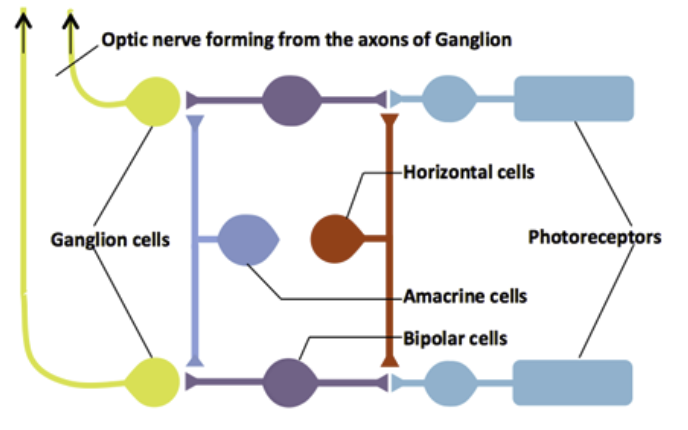

There are also different types of RGCs. Parasol RGCs are a particular type of RGC that project to magnocellular cells in the Lateral Geniculate Nucleus (LGN). Other types include midget, bistratified, and photosensitive RGCs. RGCs are also defined as ON or OFF (or more specifically, ON-center or OFF-center). This distinction refers to how the cell responds to differences in light at the center vs. edges of its receptive field. ON cells are stimulated by a stimulus to the center, and inhibited by a stimulus in the surround, whereas diffuse light will cause a weak excitation these cells. OFF cells are inhibited by a stimulus to the center, and stimulated by a stimulus in the surround, whereas
diffuse light will cause weak inhibition to these cells.




## Plotting notes

Whenever you are asked to plot anything, make sure you provide labels (axes, legends, etc.) where appropriate. 

# Question 1: Computing basic statistics and visualizing the raw data

Whenever we set out to analyze a new dataset, it’s a good idea to check the basics and make sure we know what we’re looking at before we move on to more complicated analyses. Otherwise, we might make some assumptions about the structure or properties of the data that simply aren’t true. So let’s see what we’re working with!

The following code downloads the data and saves them into 3 variables
* `Stim` holds the external visual stimuli, which is a vector with shape `(144051, 1)`. The values represent the light level of the screen (relative to a mean level of gray) at each moment in time.  
* `stimtimes` holds the stimulus frame times (i.e. the times in which the stimulus frames are shown), measured in units of seconds. The stimuli are shown at equal, regular intervals
* `SpTimes` holds the times at which the cell spiked. To get the spike times of cell 3, for example, you'd call `SpTimes[:,cellnum-1][0]`



In [9]:
# Data from Uzzell & Chichilnisky 2004
# Download data
# !wget https://github.com/anhhuyalex/neu437-537/blob/main/data_RGCs/SpTimes.mat?raw=true https://github.com/anhhuyalex/neu437-537/blob/main/data_RGCs/Stim.mat?raw=true https://github.com/anhhuyalex/neu437-537/blob/main/data_RGCs/stimtimes.mat?raw=true

# !mv SpTimes.mat?raw=true SpTimes.mat
# !mv Stim.mat?raw=true Stim.mat
# !mv stimtimes.mat?raw=true stimtimes.mat
Stim = sio.loadmat('Stim.mat')['Stim']
stimtimes = sio.loadmat('stimtimes.mat')['stimtimes']
SpTimes = sio.loadmat('SpTimes.mat')['SpTimes']


**1a**. Load the data and select cell 3 (cells 1 and 2 are the OFF cells; 3 and 4 are ON cells). Continue to use cell 3 for the remainder of this problem set, unless otherwise specified. The `stimtimes` variable 

Calculate 
* the time interval between consecutive stimuli presentations and save it to the variable `dtStim` 
* the number of stimuli presentations and save it to the variable `nT` 
* the number of spikes for cell 3 and save it to the variable `nsp`

<font color="red"> Your answer in code </font>

**(2 points)**

In [10]:
# Pick a cell to work with
cellnum = 3 # (1-2 are OFF cells; 3-4 are ON cells)
# Select the spike times for cell 3
tsp = SpTimes[:,cellnum-1][0] # get spike times for cell 3

# Compute some basic statistics on the data
dtStim = np.round(np.diff(stimtimes.reshape(stimtimes.shape[0])),7)[0] # time bin size for stimulus
nT = np.diff(stimtimes.reshape(stimtimes.shape[0])).shape[0] # number of time bins in stimulus
nsp = tsp.shape[0] # number of spikes

# Print out some basic info
print('----------------------\n')
print('Loaded RGC data: cell %d\n' %(cellnum))
print('Number of stim frames: %d (%.1f minutes)\n' %(nT,nT*dtStim/60))
print('Time bin size: %.1f ms\n' %(dtStim*1000))
print('Number of spikes: %d\n\n' %(nsp))

----------------------

Loaded RGC data: cell 3

Number of stim frames: 144050 (20.0 minutes)

Time bin size: 8.3 ms

Number of spikes: 49954




**1b**. Now let’s visualize the data. Make plots of:
* the first second of the stimulus signal (x-axis: time in seconds, y-axis: raw stimulus)
* when the neurons spiked in this interval (x-axis: time in seconds, y-axis: 1 if neuron spiked, 2 if neuron doesn't)

<font color="red"> Your answer in code </font>

**(2 points)**

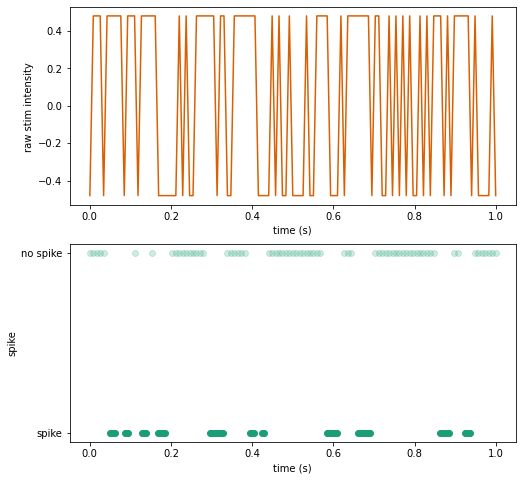

In [11]:
plt.figure(figsize=(8,8))
# YOUR CODE HERE
# plot first second of stimulus signal
plt.subplot(2,1,1)
one_sec = int(1/dtStim)
plt.plot(np.linspace(0,1, one_sec),
         Stim[:one_sec], c=colors[2])

plt.xlabel('time (s)')
plt.ylabel('raw stim intensity ')

# YOUR CODE HERE
# plot when neurons spiked
plt.subplot(2,1,2)

spike_times_in_one_sec = tsp.squeeze()[tsp.squeeze()<1]

thresh = .01

no_spikes = [x for x in np.linspace(0, 1, one_sec) \
 if (np.abs(spike_times_in_one_sec - x)).min()>thresh]


plt.scatter(spike_times_in_one_sec, 
            np.ones_like(spike_times_in_one_sec),
           color=colors[1])

plt.scatter(no_spikes, 
            2*np.ones_like(no_spikes), alpha=.2,
            color=colors[0])

plt.yticks([1,2], 
           ['spike', 'no spike'])

plt.xlabel('time (s)')
plt.ylabel('spike')
plt.show()

**1c**. Instead of looking at the raw spike times, we might also want to think about how we can relate the spike times to the stimulus more directly. One way to do this is by looking at binned spike times. This means calculating the number of spikes that occur in each stimulus time bin. Use the `np.histogram` function to bin the spike times.

To call `np.histogram`, call `np.histogram(SPIKE_TIMES, bin_edges)`, where `SPIKE_TIMES` are the spike times in the stimulus and `bin_edges` are a sequence of increasing times that define the bins. See documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)

The center of the first bin is dtStim/2 and the each bin is `dtStim` seconds wide. 

* Using `plt.stem`, create a stem plot to show the first second of binned spike times. (x-axis: binned times, y-axis: number of spikes in each time bin.)

<font color="red"> Your answer in code </font>

**(2 points)**

* What information does this stem plot tell you that the spike time plot in the previous question doesn't?

<font color="red"> Binning is the first step in later analyzing spike rate (rather than raw spike times) - as we sum the number of spikes for a given time window. This representation of the neural activity, rate, is more useful as we can assocaite it to some stimulus attributes (wherease, spike times are less relevant). </font>

**(1 point)**

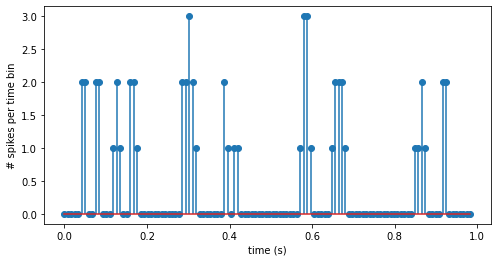

In [12]:
# Replot the responses we'll putting into our regression as counts
plt.figure(figsize=(8,4))

time_bins_one_sec = np.linspace(dtStim/2, 1, one_sec)

spikes_binned_one_sec,_ = np.histogram(spike_times_in_one_sec, 
                                       time_bins_one_sec)

plt.stem(spikes_binned_one_sec)
plt.xticks(np.linspace(0,one_sec,6), 
           np.round(np.linspace(0,1,6),1))

plt.xlabel('time (s)')
plt.ylabel('# spikes per time bin')
plt.show()

# Question 2:  Building the design matrix. 

Before we move on to actually fitting a GLM, there’s one more visualization that’s useful: the spike-triggered average (STA). The STA is the average stimulus preceding a spike. It is computed by extracting the stimulus in a given time bin prior to each spike and then averaging the resulting spike-triggered stimuli. This is a great way to characterize the response properties of a neuron and obtain an unbiased estimate of a neuron’s receptive field (note that this is only technically true if the stimulus distribution is spherically symmetric - which ours is because the stimulus is white noise!)

This sounds like a lot of work! But don't worry, we'll take it step by step. 
First, we need to assemble a matrix that contains the relevant regressors for each time bin of the response, containing the stimuli. This is called the **design matrix**. Then, we can use the vector of binned spike times that you created in question 1c. Let us call the design matrix $X$ and the vector of binned spike times $y$, and the total number of spikes $n_{sp}$. Then the STA can be computed simply as a matrix multiplication
$$ STA = \frac { 1} { n_{sp}} X^T y $$
 
 The design matrix will also be useful later on, when we are fitting the GLMs to spike train data.



2a. Here you will create a "design matrix". Each row of the matrix corresponds to a time bin and contains the relevant stimulus block for predicting the spike count at that time point. i.e. Each row of the design matrix corresponding to time bin $t$ contains the stimulus shown at times $t, t-1, t-2,\ldots,t-24$.  The matrix should be of size `(m, n)`, where m = number of time bins in the stimulus and n = size of relevant stimulus block (25). 

In doing this, it would be a good idea to first create a “padded” version of the stimulus where the first 24 time bin entries are 0. 
 
* Create a plot that shows the first 50 rows of the design matrix. 

<font color="red"> Your answer in code </font>

**(2 points)**

* What kind of pattern do you see? Why do you see this pattern? 

<font color="red"> We see a "diagonally striped" pattern. Every row is shifted from the row above it. This is the result of the the 'moving window' of bins used as predictors. The first row is only using the first bin, represented at the last element, the second row uses two bins - now the first bin is shifted to the one before last slot, as the last slot represents the second time bin. etc. Each row considers the same size stimulus block, counting from its time backwards.</font>

**(1 point)**

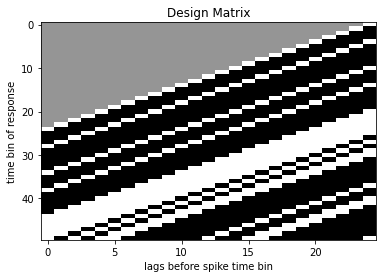

In [13]:
# YOUR CODE HERE TO CREATE DESIGN MATRIX
ntfilt = 25 
squeeze_stim = Stim.squeeze()
# design matrix
padded_stim = np.concatenate([np.zeros(ntfilt - 1), squeeze_stim])
Xdesign = hankel(padded_stim[:-ntfilt+1], squeeze_stim[-ntfilt:])


# Let's visualize a small part of the design matrix just to see it
plt.figure()
plt.imshow(Xdesign[:50], aspect='auto', 
           interpolation='nearest', 
           cmap='Greys')

plt.xlabel('lags before spike time bin')
plt.ylabel('time bin of response')
plt.title('Design Matrix')
plt.show()

**2b**. Try different values of $n$ and visualize the design matrix accordingly. 

<font color="red"> Your answer in code </font>

How do you expect GLM performance will change based on the size of the stimulus block that we use in the design matrix? 

<font color="red"> Smaller stimulus block means shorter predictor time. The GLM will focus only on very local dynamics and may miss some more global predictors.</font>

**(2 points)**

Text(0.5, 1.0, 'Design Matrix')

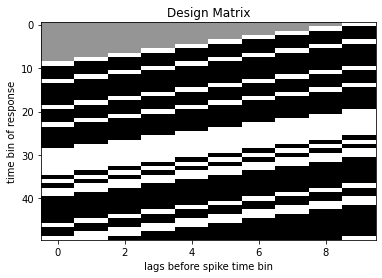

In [14]:
# YOUR CODE HERE TO CREATE DESIGN MATRIX WITH DIFFERENT n
ntfilt_alt=10
padded_stim_alt = np.concatenate([np.zeros(ntfilt_alt - 1), squeeze_stim])
Xdesign_alt = hankel(padded_stim_alt[:-ntfilt_alt+1], squeeze_stim[-ntfilt_alt:])

# Let's visualize a small part of the design matrix just to see it
plt.figure()
plt.imshow(Xdesign_alt[:50], aspect='auto', 
           interpolation='nearest', 
           cmap='Greys')

plt.xlabel('lags before spike time bin')
plt.ylabel('time bin of response')
plt.title('Design Matrix')

2c. Explain why the STA has the form
$$ STA = \frac { 1} { n_{sp}} X^T y $$
* where
  * $n_{sp}$ is the total number of spikes
  * design matrix $X$ 
  * vector of binned spikes $y$ (computed in question 1c)

<font color="red"> The STA calculates the expected value of each pixel across the set of all stimuli that evoked a spike - aiming to estimate the neuron's linear receptive field. In $X$ every row $i$ describes a stimulus vector and $y$  is a column vector where the $i$th element is the binned spikes. Their product provides a linear relationship between stimuli and spiking behavior.</font>

**(2 points)**

# Question 3: Computing and visualizing the spike-triggered average. 



**3a**. Compute the STA using the design matrix and vector binned spikes.
* Plot the STA for cells 3. (x-axis: time in seconds before spike, y-axis: stimulus value). Consider doing this in a function, as you will need to compute the STA again for cells 1, 2, 4 later on.

<font color="red"> Your answer in code </font>

**(2 points)**

* What does the plot look like? Does this make sense? Why or why not? 
 
<font color="red"> The STA shape includes an initial slow decay and a quick significant increase. Knwoing that the data reflects parasol retinal ganglion cells (RGCs)- this shape is expected. Neuron 3 is an ON RGC, the STA demosntrates the intensity change, here an increase, before the spike occurrence.</font>

**(1 point)**

* Plot the STA for each of the other cells 1,2, and 4.

<font color="red"> Your answer in code </font>

**(2 points)**

* How do the results change when using cells 1, 2, 4?  Does this make sense? Why or why not?
 
<font color="red"> We know two cells are ON cells while the other 2 are OFF cells: thus we expect two 'groups' of shapes: one depicts an increase before stimulus and the other a decrease of STA intensity. Mathematically, the STA is teh product of the stim and the spike activity. Thus, the sta of different neurons will be differenet - driven by each neuron's unique firing pattern.  see below. </font>

**(1 point)**

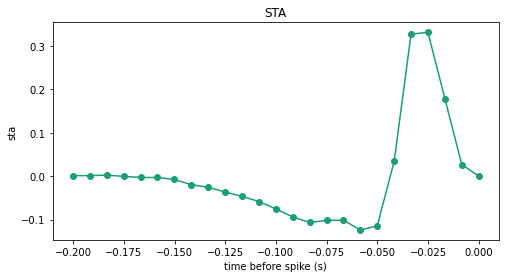

In [42]:
# YOUR CODE HERE TO COMPUTE SPIKE-TRIGGERED AVERAGE (STA)
num_spikes = tsp.size

time_bins = np.linspace(dtStim/2, (Stim.size+1) * dtStim, Stim.size+1)
spikes_binned ,_ = np.histogram(tsp.squeeze(), time_bins)

sta = (Xdesign.T @ spikes_binned)/num_spikes
bins_t = np.arange(-ntfilt+1,1)*dtStim 


# VISUALIZE STA
plt.figure(figsize=(8,4))

plt.plot(bins_t, sta, 'o-', color=colors[1])
plt.title('STA')
plt.ylabel('sta')
plt.xlabel('time before spike (s)')
plt.show()

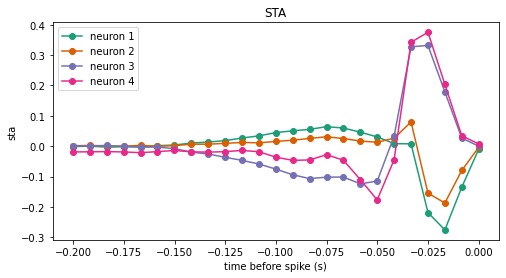

In [43]:
## STA 2/4
tsp_1 = SpTimes[:,1-1][0] # get spike times for cell 1
tsp_2 = SpTimes[:,2-1][0] # get spike times for cell 2
tsp_4 = SpTimes[:,4-1][0] # get spike times for cell 4

spikes_binned_1 ,_ = np.histogram(tsp_1.squeeze(), time_bins)
spikes_binned_2 ,_ = np.histogram(tsp_2.squeeze(), time_bins)
spikes_binned_4 ,_ = np.histogram(tsp_4.squeeze(), time_bins)

sta_1 = (Xdesign.T @ spikes_binned_1)/num_spikes
sta_2 = (Xdesign.T @ spikes_binned_2)/num_spikes
sta_4 = (Xdesign.T @ spikes_binned_4)/num_spikes


# VISUALIZE STA
plt.figure(figsize=(8,4))

plt.plot(bins_t, sta_1, 'o-', label='neuron 1', color=colors[1])
plt.plot(bins_t, sta_2, 'o-', label='neuron 2', color=colors[2])
plt.plot(bins_t, sta, 'o-', label='neuron 3', color=colors[3])
plt.plot(bins_t, sta_4, 'o-', label='neuron 4', color=colors[4])


plt.title('STA')
plt.ylabel('sta')
plt.xlabel('time before spike (s)')
plt.legend()
plt.show()

## Neurons 3 and 4 are ON RGCs and neurons 1 and 2 are OFF RGCs.

**3b)** If our stimulus were not spherically symmetric, the STA would produce a biased estimate for a linear filter. In that case, we’d need to produce a “whitened” STA, which we can do by recomputing our previous formula for the STA using a “whitening matrix.” 
$$ X_{\text{whitened}} = WX $$
Here, the whitening matrix $W$ can be defined as $W=\left(X^{T} X\right)^{-1}$, where $X$ is the design matrix.

    
* Compute the whitened design matrix 

<font color="red"> Your answer in code </font>

**(1 point)**

* Compute the STA given the whitened design matrix

<font color="red"> Your answer in code </font>

**(1 point)**

* Plot your whitened STA on the same plot as your STA (x-axis: time in seconds before spike, y-axis: stimulus value)

<font color="red"> Your answer in code </font>

**(2 points)**

* How do the whitened STA and STA compare? Is this what you expected? 

<font color="red"> The stim is symmetrical, thus there should not be a big change in shape- as $wX = (X^T * X)^{-1}$ is close to a scaled version of the identity. See below.</font>

**(1 point)**
 

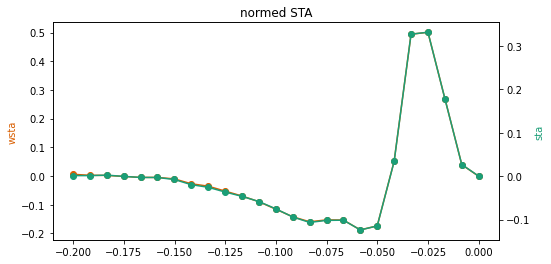

In [44]:
# YOUR CODE HERE TO COMPUTE WHITENED SPIKE-TRIGGERED AVERAGE (STA)
wXdesign =  np.linalg.inv(Xdesign.T @ Xdesign) 
wsta  = (wXdesign @ sta) * num_spikes


# VISUALIZE WHITENED STA

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(bins_t, wsta, 'o-', color=colors[2], label='wsta')
ax1.set_ylabel('wsta', color=colors[2])

ax2 = ax1.twinx()
ax2.plot(bins_t, sta, 'o-', color=colors[1], label='sta')
ax2.set_ylabel('sta', color=colors[1])

plt.title('normed STA')
plt.xlabel('time before spike (s)')

plt.show()


# Question 4: Fitting a Linear-Gaussian GLM

We'd like to fit an encoding model: predict neural activity given stimuli (stored in our design matrix). In the linear-Gaussian model, we assume that 
$$ s_i \approx \sum_j \theta_j x_{ij}$$
Where 
* $s_i$ is the neuron's predicted spikes at time $i$ (binned -- as computed in question 1c)
* $\theta_j$ is the model's parameters (to be estimated)
* $x_i$ is the  stimulus (i.e. the $i$-th row of the design matrix)

Or, if we collect all $s_i$ into a vector $\vec s$ at all times $i$ and all the parameters $\theta_j$ into a vector $\vec \theta$, we can write
$$ \vec s  \approx X\vec \theta  $$

We'd like to estimate the parameters $\vec \theta$ that minimizes the error between the predicted number of spikes and the true number of spikes. Since this is ordinary linear regression, the whitened STA corresponds to a optimal estimate of the model parameters $\theta_j$. Therefore, we can use the whitened STA to fit a linear-Gaussian GLM. 

**4a**. Use your design matrix and the STA to fit a linear-Gaussian GLM.

* Compute the predicted spikes for cell 3 across all time steps, using the whitened STA as $\theta_j$.

<font color="red"> Your answer in code </font>

**(1 point)**

 Now let’s see how good your “prediction” is (a real prediction would be performed on a separate test data set, but don’t worry about that right now)! 
* Replot your binned spike trains from 1c and your GLM prediction on the same plot. (x-axis: binned times, y-axis: number of spikes in each time bin.)

<font color="red"> Your answer in code </font>

**(1 point)**

* What do you see? Describe the relationship between spike count and GLM prediction. 

<font color="red"> The guassian GLM prediction mostly corresponds to the spike count actvitiy. However, given guassian's support being $x \in R$, there are predictions of negative spike counts, inconsistent with the non-negative anture of the quantity.</font>

**(1 point)**

* **BONUS** **(1 point)**
: Why is the whitened STA the optimal parameter setting for the linear-Gaussian GLM (i.e. linear regression)?


<font color="red"> as seen above, $wsta=(X^{T} X)^{-1}$ , the analytical solution for MLE for guassian noise is $\hat w_{LS} = (X^T X)^{-1} X^T Y$ - thus, the wsta predcition is akin to the MLE solution for guassian noise.</font>



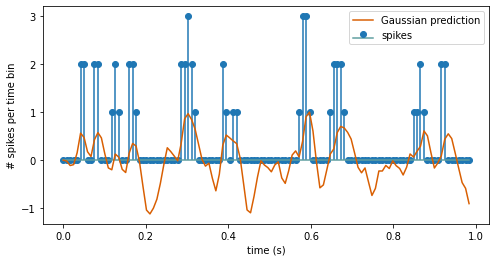

In [45]:
# FIT GLM & COMPUTE THE PREDICTED SPIKES
import statsmodels.api as sm

G_model = sm.GLM(spikes_binned, Xdesign,
                       family=sm.families.Gaussian())
G_results = G_model.fit()
G_theta = G_results.params

# predicted spikes from linear-Gaussian GLM
yhat_G_2 = Xdesign @  G_theta   

time_bins_one_sec = np.linspace(dtStim/2, 1, one_sec-1)

# PLOT BINNED SPIKE TRAINS AND GLM PREDICTION
fig, ax = plt.subplots(figsize=(8,4))

plt.stem(spikes_binned_one_sec, label='spikes', basefmt="cadetblue")
plt.plot(yhat_G_2[:one_sec-1], c=colors[2], label='Gaussian prediction')

plt.xticks(np.linspace(0,one_sec,6), 
           np.round(np.linspace(0,1,6),1))

plt.xlabel('time (s)')
plt.ylabel('# spikes per time bin')
plt.legend()
plt.show()

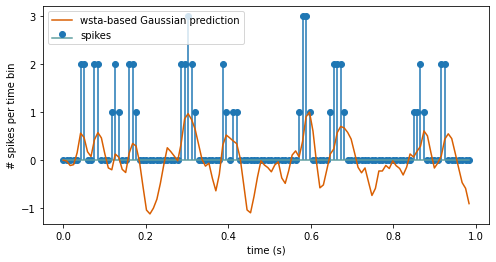

In [19]:
y_hat_wsta = Xdesign @  wsta   

fig, ax = plt.subplots(figsize=(8,4))

plt.stem(spikes_binned_one_sec, label='spikes', basefmt="cadetblue")
plt.plot(y_hat_wsta[:one_sec-1], c=colors[2], label='wsta-based Gaussian prediction')

plt.xticks(np.linspace(0,one_sec,6), 
           np.round(np.linspace(0,1,6),1))

plt.xlabel('time (s)')
plt.ylabel('# spikes per time bin')
plt.legend()
plt.show()



**4b**. One thing we forgot to do was include a **bias** (also called **offset**) or “constant” term in the design matrix. This is important because it will allow our prediction to have a non-zero mean (even though the stimulus was normalized to have zero mean). 

* Create a new design matrix with an additional column of 1’s as the first column, recompute the STA, and calculate a new GLM prediction. 

<font color="red"> Your answer in code </font>

**(1 point)**

* Plot the binned spike times and both predictions on one plot. 

<font color="red"> Your answer in code </font>

**(1 point)**

* What do you see? Which GLM prediction better fits the spike counts?

<font color="red">The constant added to the design matrix allows the prediction to have non-zero mean (since the stimulus here was normalized to have zero mean)- and expected to fit better. Training "fit" $R^2$ reported below shows that the constant does increase the quality of the prediction</font>

**(1 point)**


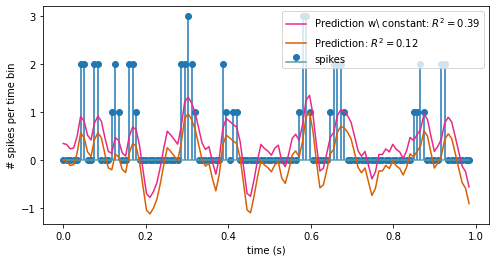

In [21]:
# FIT GLM & COMPUTE THE PREDICTED SPIKES OF NEW MODEL

const_Xdesign = np.column_stack((np.ones((Stim.size,1)), Xdesign))

const_sta = (const_Xdesign.T @ spikes_binned)/num_spikes
const_wsta  = (np.linalg.inv(const_Xdesign.T @ const_Xdesign) @ const_sta) * num_spikes


y_hat_const_wsta = const_wsta[0] + Xdesign @ const_wsta[1:]  


### training accuracy

mse_G_wsta = np.mean((spikes_binned-y_hat_wsta)**2) 
mse_G_constant_wsta = np.mean((spikes_binned-y_hat_const_wsta)**2) 
rss = np.mean((spikes_binned-np.mean(spikes_binned))**2)  
 # PLOT BINNED SPIKE TRAINS AND GLM PREDICTION

fig, ax = plt.subplots(figsize=(8,4))

plt.stem(spikes_binned_one_sec, label='spikes', basefmt="cadetblue")
plt.plot(y_hat_const_wsta[:one_sec-1], c=colors[4], 
         label=r'Prediction w\ constant: $R^2=${}'.format(np.round(1-mse_G_constant_wsta/rss,2)))
plt.plot(y_hat_wsta[:one_sec-1], c=colors[2], 
         label=r'Prediction: $R^2=${}'.format(np.round(1-mse_G_wsta/rss,2)))

plt.xticks(np.linspace(0,one_sec,6), 
           np.round(np.linspace(0,1,6),1))

plt.xlabel('time (s)')
plt.ylabel('# spikes per time bin')
plt.legend()
plt.show()



**4c**. How good is our prediction? 
* Calculate the mean squared error of the spike train, the GLM without offset, and the GLM with offset. 

<font color="red"> Your answer in code </font>

**(1 point)**

* Then calculate the training performance of each fit as:  
$$ R^2 = 1 - \frac { GLM_{error}} {st_{error} }$$

where $R^2$ is the training performance, $GLM_{error}$ is the mean squared error of the GLM, and $st_{error}$ is the spike train error.


Again, it would be a good idea to use functions here, as you will need to reuse this code

* Print your results. 

<font color="red"> Your answer in code </font>

**(1 point)**

* What do these results tell us? 

<font color="red">see above. </font>

**(1 point)**


In [22]:
# COMPUTE MEAN SQUARED ERROR AND TRAINING PERFORMANCE
mse_nobias = mse_G_wsta# model with no bias
mse_withbias = mse_G_constant_wsta# model with bias

r2_nobias = np.round(1-mse_G_wsta/rss,2)
r2_withbias = np.round(1-mse_G_constant_wsta/rss,2)
print('Mean squared error: lin-gauss GLM. no offset: %.2f\n' %mse_nobias)
print('Mean squared error: lin-gauss GLM. with offset: %.2f\n' %mse_withbias)
print('Training perf (R^2): lin-gauss GLM. no offset: %.2f\n' %r2_nobias)
print('Training perf (R^2): lin-gauss GLM. with offset: %.2f\n' %r2_withbias)

Mean squared error: lin-gauss GLM. no offset: 0.39

Mean squared error: lin-gauss GLM. with offset: 0.27

Training perf (R^2): lin-gauss GLM. no offset: 0.12

Training perf (R^2): lin-gauss GLM. with offset: 0.39



**4d**. Now go back, change the size of the stimulus block for your design matrix, and rerun all the subsequent results up to this point to get new values for the training performance. Do this for a couple different values of stimulus block size $n$ in the design matrix.
* Specifically, for a design matrix with given value of $n$, fit a linear-Gaussian model, plot the binned spike times and your GLM prediction, calculate the mean squared error, and then calculate the training performance $R^2$ of each fit. 

<font color="red"> Your answer in code </font>

**(1 point)**

*  Describe visually how the GLM prediction changes as a function of $n$ compared to the binned spike times. How does changing the size of your stimulus block $n$ affect the training performance $R^2$ and the mean squared error of the fitted models?

<font color="red"> Your answer in code </font>

**(1 point)**

* Are the results the same or different from what you predicted would happen in 2b? 

<font color="red"> Your answer in code </font>

**(1 point)**


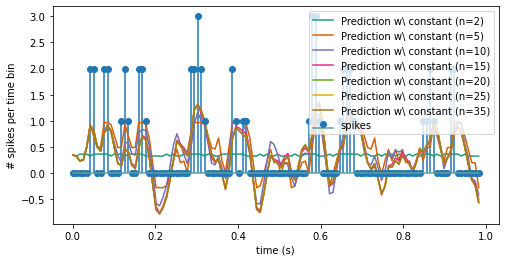

In [23]:
# COMPUTE DESIGN MATRIX
#n=10 from above

fig, ax = plt.subplots(figsize=(8,4))
mses = []
r2_s = []
for n_i, ntfilt_alt in enumerate([2, 5, 10, 15, 20, 25, 35]):
    # FIT GLM & COMPUTE THE PREDICTED SPIKES

    padded_stim_alt = np.concatenate([np.zeros(ntfilt_alt - 1), squeeze_stim])
    Xdesign_alt = hankel(padded_stim_alt[:-ntfilt_alt+1], squeeze_stim[-ntfilt_alt:])

    const_alt_Xdesign = np.column_stack((np.ones((Xdesign_alt.shape[0],1)), 
                                         Xdesign_alt))

    const_alt_sta = (const_alt_Xdesign.T @ spikes_binned)/num_spikes
    const_alt_wsta  = (np.linalg.inv(const_alt_Xdesign.T @ const_alt_Xdesign) @ const_alt_sta) * num_spikes

    y_hat_const_alt_wsta = const_alt_wsta[0] + Xdesign_alt @ const_alt_wsta[1:]  

    ### accuracy(ish)

    mse_G_alt_const_wsta = np.mean((spikes_binned-y_hat_const_alt_wsta)**2) 
    mses.append(mse_G_alt_const_wsta)
    r2_s.append(1-mse_G_alt_const_wsta/rss)
######


    
    plt.plot(y_hat_const_alt_wsta[:one_sec-1], c=colors[n_i+1],
             label=r'Prediction w\ constant (n={})'.format(ntfilt_alt))

plt.stem(spikes_binned_one_sec, label='spikes', basefmt="cadetblue")
plt.xticks(np.linspace(0,one_sec,6), 
           np.round(np.linspace(0,1,6),1))
    
plt.xlabel('time (s)')
plt.ylabel('# spikes per time bin')
plt.legend()
plt.show()

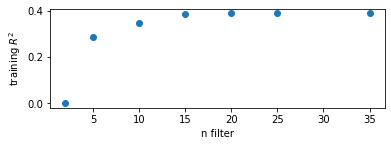

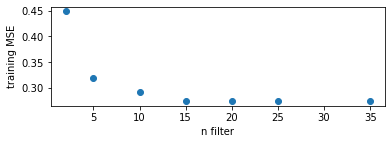

In [24]:
#plt.scatter([2, 5, 10,15, 25, 35], mses)
plt.subplot(2,1,1)
plt.scatter([2, 5, 10,15, 20, 25, 35], r2_s)
plt.ylabel(r'training $R^2$')
plt.xlabel('n filter')
plt.show()
plt.subplot(2,1,2)
plt.scatter([2, 5, 10,15, 20, 25, 35], mses)
plt.ylabel(r'training MSE')
plt.xlabel('n filter')
plt.show()

## there is an increase (decrease) of R^2 (MSE) with the increase of n filter size, 
# that saturates at r^2 ~.4, (MSE=.3) at around n~=15

# Question 5: Fitting a Poisson GLM. 

Is a linear-Gaussian GLM the best way to fit our spike train data? Or is there a better option? 


**5a**. Using the relevant code, your design matrix with a bias (that you constructed in question 4b), and the binned spike train (that you constructed in quesetion 1c), fit a Poisson GLM. Make sure you select Poisson as your distribution function. Note that you should also set the following parameters: `learning_rate=1.0` and `reg_lambda=1e-7`. 

In other words, the model will assume that
$$ s_i \sim \text{Poisson} \left ( \exp \left [ \sum_j \theta_j x_{ij}\right ] \right ) $$

i.e. The total number of binned spikes at time $i$ will be drawn from a Poisson distribution with mean rate $\mu_i = \exp \left [ \sum_j \theta_j x_{ij}\right ]  $

* The model will compute the weight vector $\vec \theta $ that will minimize the Poisson likelihood of the data (i.e. the probability of the spikes $s_i$ at time $i$ given the weight vector $\vec \theta $)

* Once you have the weights (also called the **kernel** or **filter**), the line `ratepred_pGLM = glm_poisson.predict(design_matrix)` calculates the predicted spike rate on the data (the design matrix) using the fitted weights
* Create a plot of the kernel for the linear-Gaussian with bias model and the poisson GLM model. (For the linear-Gaussian with bias case, don’t include the offset weight in your plot). 

<font color="red"> Your answer in code </font>

**(3 points)**

* How do the two kernels compare? Is this what you expected?

<font color="red"> The Poisson generates a larger kernel than the Guassian. </font>

**(1 point)**

* Create another plot of the predicted spike rates for the linear-Gaussian with bias and poisson GLMs overlayed on a stem plot of the actual (binned) spike counts. 

<font color="red"> Your answer in code </font>

**(3 point)**


* Calculate and print the training performance $R^2$ of the poisson GLM. 

<font color="red"> Your answer in code </font>

**(1 point)**

* Which type of GLM is a better fit to the data? Why do you think this is true?

<font color="red"> The Poisson GLM fits better: this is not surprising, a neuron probability of firing is better described by a poisson distrcution, (a) it is non negative (b) it is discrete, and (c) it is non linear. </font>

**(1 point)**


In [72]:
# use the GLM class from pyglmnet to fit Poisson GLM from the pyglmnet package
glm_poisson = GLM(distr='poisson',
                  learning_rate=1.0,
                  score_metric='pseudo_R2',
                  reg_lambda=1e-7)

# fit GLM
design_matrix = Xdesign# design_matrix that you constructed in 4b -- feel free to rename this variable..
binned_spks = spikes_binned # binned spike train -- feel free to rename this variable..
glm_poisson.fit(design_matrix, binned_spks) # fit !

pGLMwts = glm_poisson.beta_ # extract weights from fitted Poisson GLM

# predict spike counts
ratepred_pGLM = glm_poisson.predict(design_matrix)


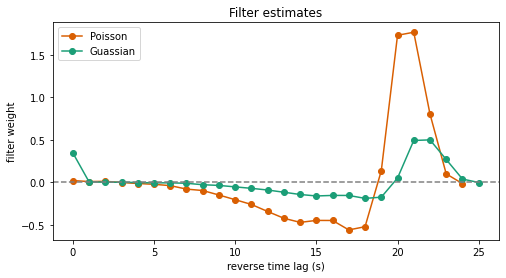

In [73]:

# PLOT WEIGHTS OF POISSON GLM VS. LINEAR-GAUSSIAN GLM
plt.figure(figsize=(8,4))

plt.title('Filter estimates')
plt.plot(pGLMwts, marker="o",  color=colors[2], label='Poisson')
plt.plot(const_wsta, marker="o", color=colors[1], label='Guassian')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel("reverse time lag (s)")
plt.ylabel("filter weight")
plt.legend()
plt.show()



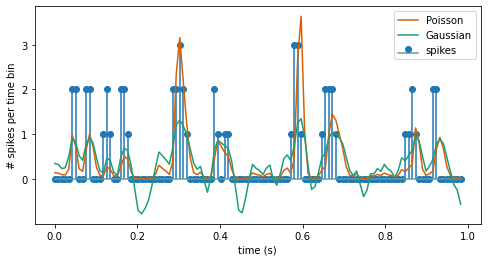

In [47]:
# PLOT PREDICTED SPIKE RATES OF POISSON GLM VS. LINEAR-GAUSSIAN GLM
plt.figure(figsize=(8,4))

plt.stem(spikes_binned_one_sec, label='spikes', basefmt="cadetblue")
plt.plot(ratepred_pGLM[:one_sec-1], c=colors[2], 
             label=r'Poisson')

plt.plot(y_hat_const_wsta[:one_sec-1], c=colors[1], 
             label=r'Gaussian')

plt.xlabel('time (s)')
plt.ylabel('# spikes per time bin')
plt.legend()
plt.xticks(np.linspace(0,one_sec,6), 
           np.round(np.linspace(0,1,6),1))
plt.show()



In [28]:
# COMPUTE MEAN SQUARED ERROR AND TRAINING PERFORMANCE

mse_P = np.mean((spikes_binned-ratepred_pGLM)**2)
mse_G = np.mean((spikes_binned-y_hat_const_wsta)**2)
r2_P = (1-mse_P/rss)
r2_G = (1-mse_G/rss)


print('Mean squared error: Gaussian: %.2f\n' %mse_G)
print('Mean squared error: Poisson: %.2f\n' %mse_P)
print('Training perf (R^2): Gaussian: %.2f\n' %r2_G)
print('Training perf (R^2): Poisson: %.2f\n' %r2_P)

### a Poisson GLM shows a better fit (smaller MSE and higher R^2)

Mean squared error: Gaussian: 0.27

Mean squared error: Poisson: 0.22

Training perf (R^2): Gaussian: 0.39

Training perf (R^2): Poisson: 0.51



**5b**. The fitting code you used in 5a assumes a GLM with an exponential nonlinearity (i.e., governing the mapping from filter output to instantaneous spike rate). But how adequate is this assumption? We can examine this question by comparing the results to a “nonparametric” estimate of the nonlinearity (in other words, an estimate derived from the data itself without any assumptions as to the appropriate parameters or form of the function). In other words, we assume that
$$ s_i \sim \text{Poisson} \left ( f \left [ \sum_j \theta_j x_{ij}\right ] \right ) $$

i.e. The total number of binned spikes at time $i$ will be drawn from a Poisson distribution with mean rate $\mu_i = f \left [ \sum_j \theta_j x_{ij}\right ]  $
* Where 
  * $s_i$ is the neuron's predicted spikes at time $i$ (binned -- as computed in question 1c)
  * $\theta$ is the Poisson GLM's parameters (estimated in question 5a)
  * $x_i$ is the  stimulus (i.e. the $i$-th row of the design matrix)
  * $f$ is our non-linearity mapping from filtered output $\sum_j \theta_j x_{ij}$ to a mean spike rate, which we will construct non-parametrically
    * $f$ is implemented as a look-up table where $f(x)$ is equal to the mean number of spikes elicited by the filtered stimulus value $x$
* To construct $f$,
  1. First, use the design matrix $X$ and the learned Poisson GLM weight vector $\theta$ to compute the filtered stimulus $\sum_j \theta_j x_{ij}  $
  2. Then, bin the output into 25 bins as in question 1c (using `np.histogram`). Then, compute the bin centers. This will serve as the inputs to the function $f$
  3. Next, compute the mean spike count in each bin and divide your result by the bin size to get units of spikes/second. This will serve as the outputs to the function $f$.
  4. To evaluate the link function $f$ at an arbitrary value $x$, $f(x)$ is the interpolated value defined by the look up table (bin edges, mean spike count). Read the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) for the function `np.interp`

 
* Using x values that range from the left most to right most bin edges and increment in steps of 0.01, plot the exponential function and your nonparametric function $f$ on one plot.  (x-axis: filtered stimulus, y-axis: mean spike rate)

<font color="red"> Your answer in code </font>

**(2 points)**

* From this plot, what do you think of the exponential link function? Does this seem like a good approximation to the nonparametric estimate of the nonlinearity? 

<font color="red"> The nonparametric fit overcomes the main issue with the exponential fit - it saturates at some value - which is likely what is happening in the data (firing rate can not be infinite). </font>

**(1 point)**

* Can you propose a better parametric nonlinearity (other than an exponential) instead?  

<font color="red"> A sigmoid function could be a parametric solution for the saturation.</font>

**(1 point)**


In [29]:
# CONSTRUCT NONPARAMETRIC f
# number of bins for parametrizing the nonlinearity f. (Try varying this!) 
num_bins = 25

# compute filtered stimulus
raw_filter_output = pGLMwts[0] + Xdesign @ pGLMwts[1:]

# bin the output into 25 bins
counts, bin_edges = np.histogram(raw_filter_output, num_bins)
bin_idx = np.digitize(raw_filter_output, bins=bin_edges) - 1

# compute the mean spike count 
f_x = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2 
f_y = np.array([np.mean(spikes_binned[bin_idx==i])\
                for i in range(num_bins)])/dtStim

# evaluate the link function  
f_link = interp1d(f_x, f_y,
                   kind='nearest', bounds_error=False, 
                   fill_value='extrapolate')




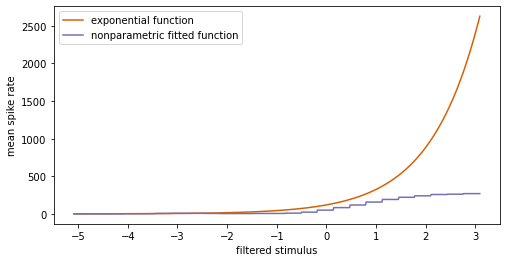

In [48]:
# PLOT EXPONENTIAL AND NONPARAMETRIC FUNCTION f
x_range = np.arange(bin_edges[0], bin_edges[-1]+.01, step=.01)
plt.figure(figsize=(8,4))

plt.plot(x_range, np.exp(x_range)/dtStim, 
         label='exponential function', c=colors[2])

plt.plot(x_range, f_link(x_range), 
         label='nonparametric fitted function', c=colors[3])
plt.legend()
plt.xlabel('filtered stimulus')
plt.ylabel('mean spike rate')
plt.show()

**5c**. Finally, let’s do a direct comparison of our two nonlinearities for the Poisson GLM to see which provides a better fit to the data. To do this, we are going to calculate the log-likelihood of the fits. The log likelihood tells us the likelihood that the data is explained by our GLM predictions. The equation for the Poisson log-likelihood is:  
$$ \begin{aligned}
\log (P(s_i \mid \mu_i))&=\log (\text{Poisson}(s_i \mid \mu_i))\\&=s_i \log (\mu_i)-\mu_i
\end{aligned}
 $$
Where 
* $s_i$ is the spike count in the time bin  $i$
* $\mu_i$ is the model's predicted spike rate for the neuron (known as "conditional intensity")  at time bin $i$. $\mu_i$ has units in units of spikes/bin


This is equivalent to the likelihood
$$  (P(s_i \mid \mu_i))\propto \mu_i^{s_i}   e^{-\mu_i} $$

Then, we assume that the neuron behaves independent at all time bins, so that the log-likelihood for the data set turns into a sum
$$ \log (P(\vec s   \mid \vec\mu ))  = \sum_i \log (P(s_i \mid \mu_i)) $$
Where 
* $\vec s$ is the vector of the neuron's spike count at all times
* $\vec\mu $ is the model's predicted spike rate at all times


 Typically, the log-likelihood is a negative value, but the higher the value (the closer to zero) the better the prediction is.


* Calculate the log-likelihood for the exponential and non-parametric GLMs and print your results. (Note: you will likely get a log of zero error when calculating the LL in the nonparametric case. Calculating the first term in the log-likelihood only for the time points where the spike count $s_i$> 0 should solve this problem). 

<font color="red"> Your answer in code </font>

 **(2 points)**


* Which GLM prediction better fits the data? Are you surprised by this? Why or why not?

<font color="red"> The non parametric has a lower negative log likelihood value 
(and a lower AIC, $AIC =  2*k - 2*ll$)  - indicating its has the better fit of the two tested models. This is not surpsiging given that the nonlinearity is not strictly exponentiatl, and more freedom, i.e., ridding this assumption, could generate a better model. However, I suspect that an unreasonable increase of the number of parameters would lower the nonparamtric fit (due to increased variance). </font>

**(1 point)**


In [67]:
## Exponential 
ratepred_pGLM = np.exp(raw_filter_output)
ll_exp = spikes_binned.T @ np.log(ratepred_pGLM) - np.sum(ratepred_pGLM)
AIC_exp = -2*ll_exp + 2*(1+ntfilt);


ratepred_npGLM = dtStim * f_link(raw_filter_output)
ll_np = spikes_binned[spikes_binned>0].T @ np.log(ratepred_npGLM[spikes_binned>0]) - np.sum(ratepred_npGLM)
AIC_np = -2*ll_np + 2*(1+ntfilt+num_bins)


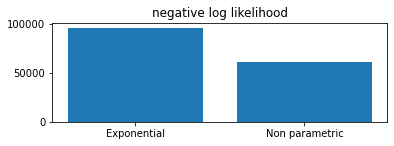

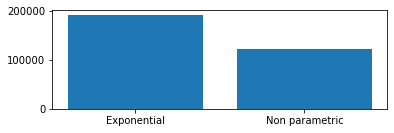

In [71]:
plt.subplot(2,1,1)

plt.title('negative log likelihood')
plt.bar(['Exponential','Non parametric'], -1*np.array([ll_exp, ll_np ]))

plt.show()
plt.subplot(2,1,2)
plt.bar(['Exponential','Non parametric'], [AIC_exp, AIC_np ])
plt.show()




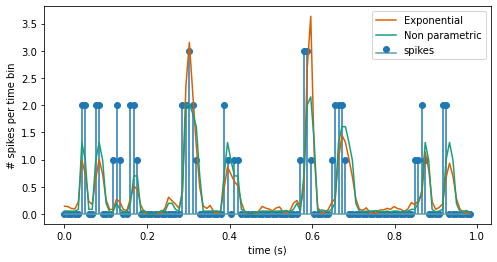

In [49]:
plt.figure(figsize=(8,4))

plt.stem(spikes_binned_one_sec, label='spikes', basefmt="cadetblue")
plt.plot(ratepred_pGLM[:one_sec-1], c=colors[2], 
             label=r'Exponential')

plt.plot(ratepred_npGLM[:one_sec-1], c=colors[1], 
             label=r'Non parametric')

plt.xlabel('time (s)')
plt.ylabel('# spikes per time bin')
plt.legend()
plt.xticks(np.linspace(0,one_sec,6), 
           np.round(np.linspace(0,1,6),1))
plt.show()

5d. Ok, now let’s close by reflecting on our results and thinking about other applications. 
* What do your different results in questions 4 and 5 tell you about what you should think about when using GLMs to model neural data?

<font color="red"> The chosen model imposes assumptions on the analysis - and must be aware of that: our choice of parameters (i.e bin size, filter size, etc.) \& our choice of the model itself (linear vs non linear, parametric vs non parametric) by themselves affect the results - and should be considered in the analysis. </font>

**(2 points)**
